In [2]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math
from statsmodels.tsa.seasonal import seasonal_decompose

# plt.style.use('fivethirtyeight')

In [3]:
y = pd.read_csv('../notebooks/datasets/AirPassengers.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

In [4]:
print(y.head(n=5))

date
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: values, dtype: int64


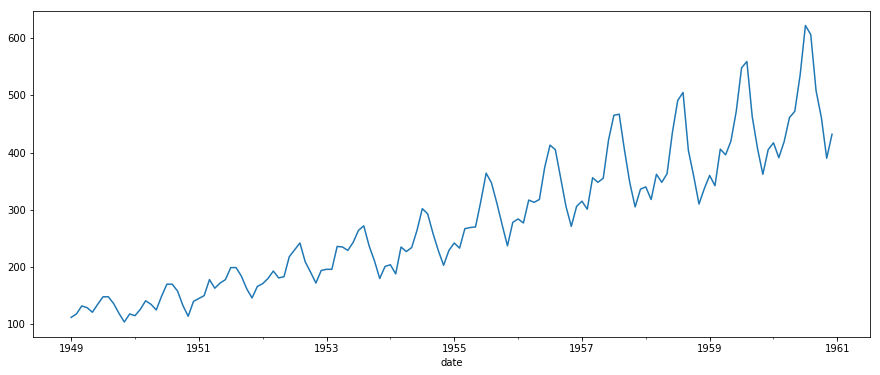

In [5]:
y.plot(figsize=(15, 6))
plt.show()

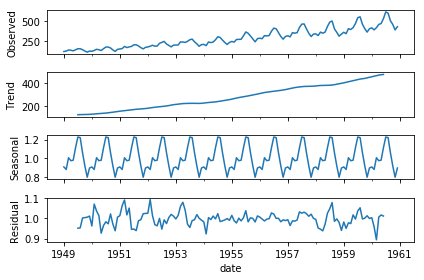

In [6]:
result = seasonal_decompose(y, model='multiplicative')

result.plot()
plt.show()

In [7]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [8]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue            

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1886.5367342423006
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1156.2914901508536
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1118.6259190717344
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1107.2562043235264
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1109.2437994445113
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1033.6172166729975
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1846.07893775716
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1567.9916312319167
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1196.9983614399948
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1072.1382984044358
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1071.0026807710476
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1049.5801405528614
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1059.5112223290457
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:985.3346478032901
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1194.7130010979627
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:937.7995265380565
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:1031.4838983661916
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1015.0000347579

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3351      0.076     -4.403      0.000      -0.484      -0.186
ar.S.L12      -0.5597      0.285     -1.967      0.049      -1.117      -0.002
ma.S.L12       0.4077      0.336      1.212      0.225      -0.251       1.067
sigma2       140.2869     18.080      7.759      0.000     104.852     175.722


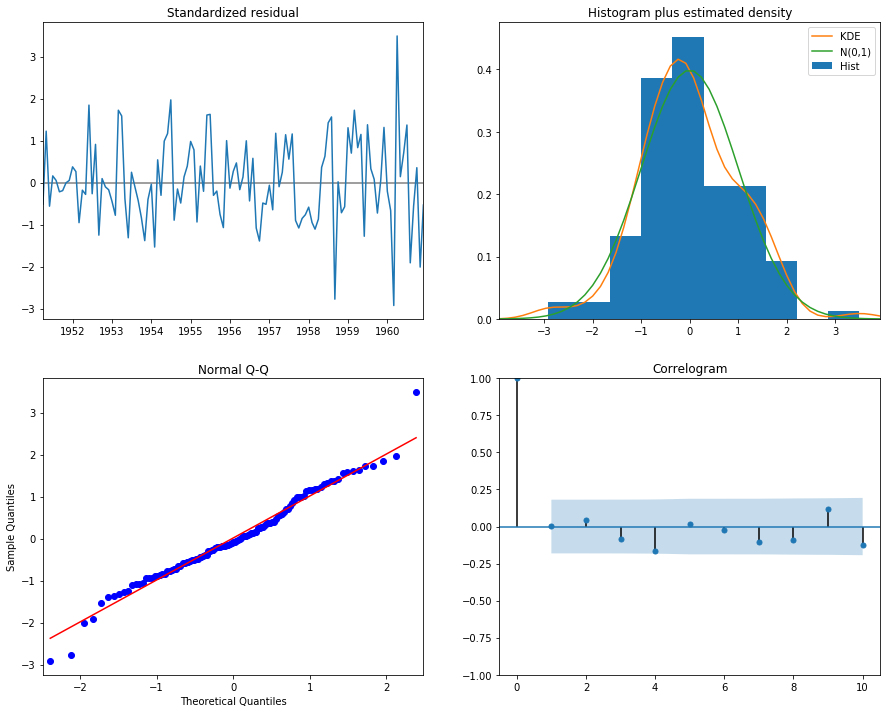

In [9]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

results.plot_diagnostics(figsize=(15, 12))
plt.show()

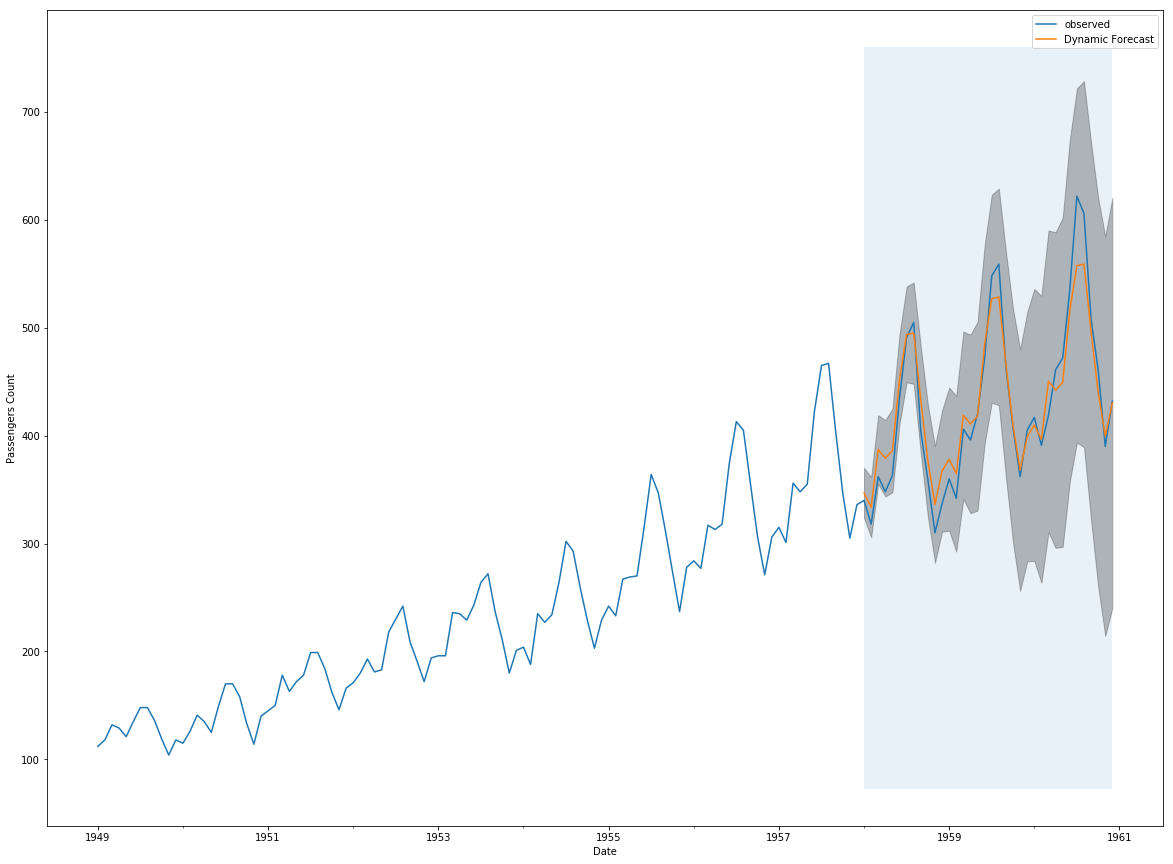

In [10]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1958-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = y['1949':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1958-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Passengers Count')

plt.legend()
plt.show()

In [11]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['1958-01-01':]

# Compute the mean square error
rmse = math.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of our forecasts is 22.21


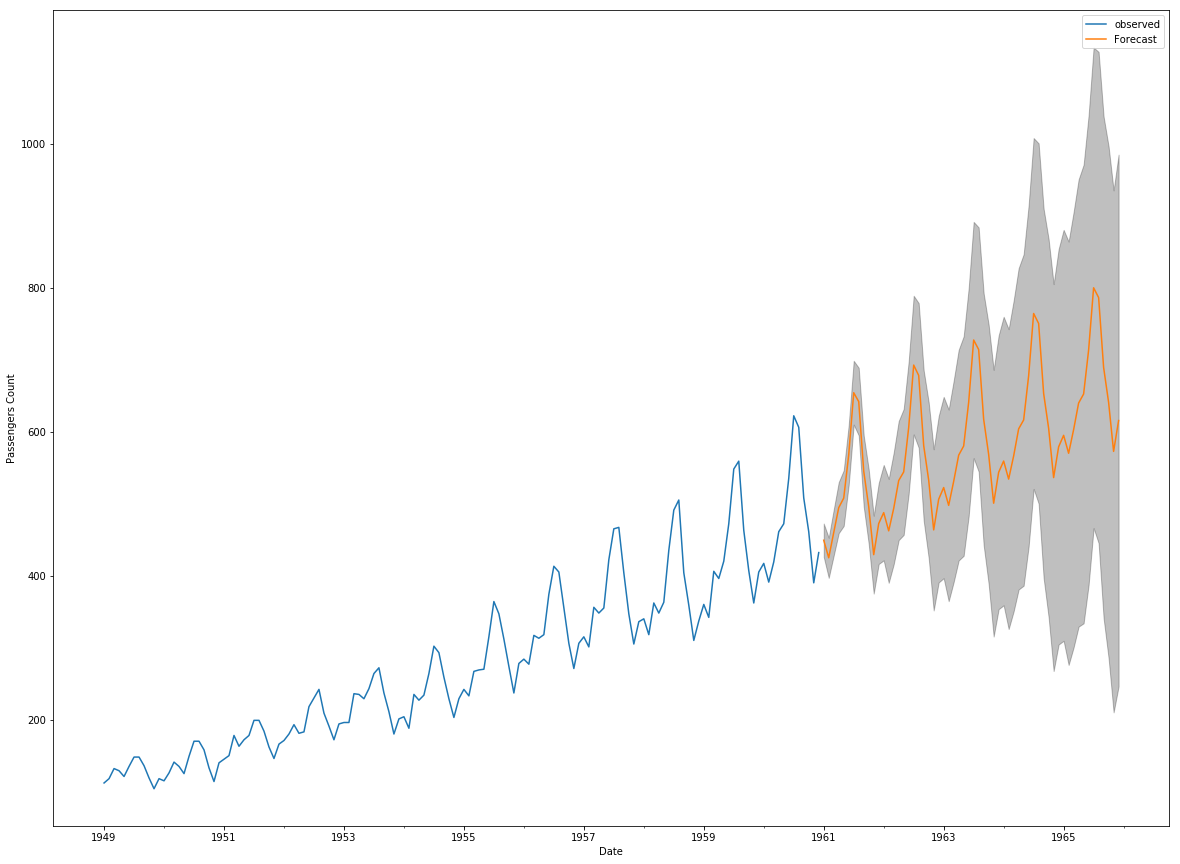

In [12]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=60)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Passengers Count')

plt.legend()
plt.show()